### Imports

In [1045]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error

In [1046]:
raw_train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
raw_train.head()

,Length (cm),Width (cm),Weight (g),Pericarp Thickness (mm),Seed Count,Capsaicin Content,Vitamin C Content (mg),Sugar Content,Moisture Content,Firmness,color,Harvest Time,Average Daily Temperature During Growth (celcius),Average Temperature During Storage (celcius),Scoville Heat Units (SHU)
0,17.37,5.42,94.30,4.90,193.93,3.21,173.59,6.15,88.59,3.40,red,Midday,8.68,5-6,0.00
1,27.78,4.75,262.71,6.56,186.29,8.19,100.41,2.36,111.20,5.45,green,Midday,22.44,NaN,0.00
2,6.17,3.51,66.72,7.96,298.81,4.69,125.91,6.75,72.98,2.77,red,Midday,24.99,NaN,455995.06
3,6.12,6.07,51.24,4.57,39.36,2.76,143.54,5.93,63.93,1.62,yellow,Midday,13.05,NaN,0.00
4,28.58,4.84,166.51,3.07,194.07,7.01,193.76,2.85,88.19,3.99,red,Midday,27.08,NaN,0.00


In [1047]:
raw_train.describe()

,Length (cm),Width (cm),Weight (g),Pericarp Thickness (mm),Seed Count,Capsaicin Content,Vitamin C Content (mg),Sugar Content,Moisture Content,Firmness,Average Daily Temperature During Growth (celcius),Scoville Heat Units (SHU)
count,999.000000,999.000000,999.000000,998.000000,999.000000,999.000000,1000.000000,999.000000,1000.000000,999.000000,1000.000000,1000.000000
mean,15.574675,6.641572,169.346406,4.619499,128.731301,4.215385,142.035180,3.283534,90.878380,3.679179,19.641960,70941.260020
std,6.267303,2.139023,123.779026,2.829503,87.270366,3.163125,72.246142,1.938264,18.724314,1.034726,6.436255,108149.917069
min,0.300000,0.100000,0.560000,0.000000,0.040000,0.010000,0.950000,0.010000,31.400000,0.850000,0.840000,0.000000
25%,11.290000,5.140000,79.020000,2.400000,55.390000,1.710000,92.290000,1.865000,78.585000,2.980000,15.397500,0.000000
50%,15.520000,6.600000,147.230000,4.280000,119.490000,3.590000,141.730000,3.140000,89.690000,3.660000,19.495000,0.000000
75%,19.900000,8.045000,227.625000,6.560000,186.845000,6.115000,192.720000,4.555000,103.200000,4.375000,23.530000,121349.617500
max,35.570000,13.620000,869.970000,14.630000,487.260000,19.020000,450.290000,9.360000,158.300000,8.250000,40.700000,527639.860000


In [1048]:
# check for missing data
print(raw_train.isnull().sum()) 

print(test.isnull().sum())

Length (cm)                                            1
Width (cm)                                             1
Weight (g)                                             1
Pericarp Thickness (mm)                                2
Seed Count                                             1
Capsaicin Content                                      1
Vitamin C Content (mg)                                 0
Sugar Content                                          1
Moisture Content                                       0
Firmness                                               1
color                                                  1
Harvest Time                                           0
Average Daily Temperature During Growth (celcius)      0
Average Temperature During Storage (celcius)         648
Scoville Heat Units (SHU)                              0
dtype: int64
Length (cm)                                            2
Width (cm)                                             0
Weight (g)        

In [1049]:
# drop the column 'Average Temperature During Storage (celcius)' as it has too many missing values
train = raw_train.drop(['Average Temperature During Storage (celcius)'], axis=1)
test = test.drop(['Average Temperature During Storage (celcius)'], axis=1)

print(train.shape)
print(test.shape)

(1000, 14)
(800, 13)


In [1051]:

# Combine train and test DataFrames into a single list
data = [train, test]

# List of numeric columns
numeric_cols = ['Length (cm)', 'Width (cm)', 'Weight (g)', 'Pericarp Thickness (mm)', 'Seed Count', 'Capsaicin Content', 'Sugar Content','Moisture Content', 'Firmness']

# Fill missing values in numeric columns with the mean for both train and test DataFrames
for df in data:
    for col in numeric_cols:
        df[col] = df[col].fillna(df[col].mean())

# Fill missing values in categorical columns with the mode from the 'train' DataFrame for the 'test' DataFrame
categorical_cols = ['color', 'Harvest Time']
for col in categorical_cols:
    for df in data:
        df[col] = df[col].fillna(data[0][col].mode().iloc[0])

# Check for missing data
print("Missing values in train DataFrame:")
print(train.isnull().sum())

print("\nMissing values in test DataFrame:")
print(test.isnull().sum())


Missing values in train DataFrame:
Length (cm)                                          0
Width (cm)                                           0
Weight (g)                                           0
Pericarp Thickness (mm)                              0
Seed Count                                           0
Capsaicin Content                                    0
Vitamin C Content (mg)                               0
Sugar Content                                        0
Moisture Content                                     0
Firmness                                             0
color                                                0
Harvest Time                                         0
Average Daily Temperature During Growth (celcius)    0
Scoville Heat Units (SHU)                            0
dtype: int64

Missing values in test DataFrame:
Length (cm)                                          0
Width (cm)                                           0
Weight (g)                           

In [1030]:
# violin plot
#fig_violin, ax_violin = plt.subplots(nrows=3, ncols=5, figsize=(16, 9))
#plt.tight_layout(pad=3.0)

#i = 0
#for row in range(3):
    #for col in range(5):
        #sns.violinplot(ax=ax_violin[row, col], data=raw_train, x='Scoville Heat Units (SHU)', y=raw_train.columns[i], 
                       #hue='Scoville Heat Units (SHU)', split=True) # the split makes it easier to see the differenvce for edible 1 or 0
        #i += 1
        
#plt.show()

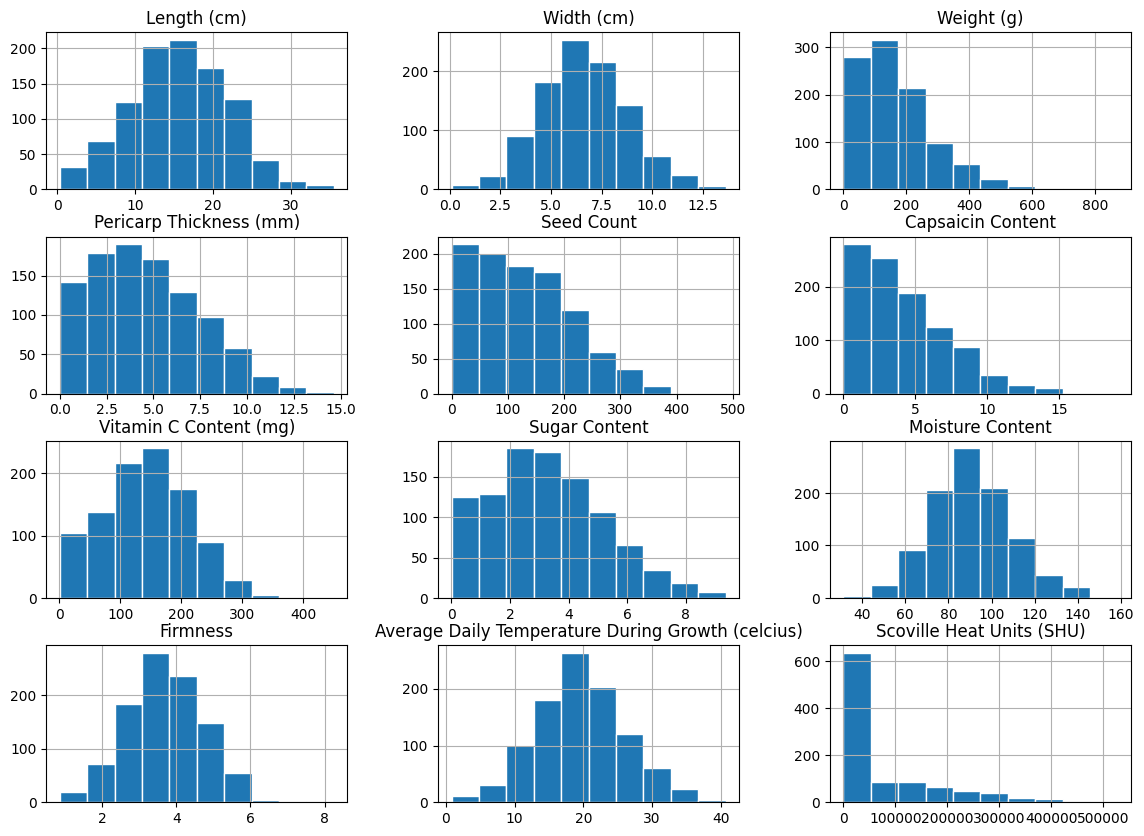

In [1031]:
# Histogram 
# Histogram for each feature
raw_train.hist(bins=10, figsize=(14,10), edgecolor='white')
plt.show()

In [1033]:
numeric_cols = ['Length (cm)', 'Width (cm)', 'Weight (g)', 'Pericarp Thickness (mm)', 'Seed Count', 'Capsaicin Content', 'Sugar Content', 'Firmness']
test[numeric_cols] = test[numeric_cols].fillna(test[numeric_cols].mean())

# Fill missing values in categorical columns with the mode
categorical_cols = ['color', 'Harvest Time']
test[categorical_cols] = test[categorical_cols].fillna(test[categorical_cols].mode().iloc[0])

# check for missing data
print(test.isnull().sum())

Length (cm)                                          0
Width (cm)                                           0
Weight (g)                                           0
Pericarp Thickness (mm)                              0
Seed Count                                           0
Capsaicin Content                                    0
Vitamin C Content (mg)                               0
Sugar Content                                        0
Moisture Content                                     1
Firmness                                             0
color                                                0
Harvest Time                                         0
Average Daily Temperature During Growth (celcius)    0
dtype: int64


In [1034]:
# data types
print(train.dtypes)

Length (cm)                                          float64
Width (cm)                                           float64
Weight (g)                                           float64
Pericarp Thickness (mm)                              float64
Seed Count                                           float64
Capsaicin Content                                    float64
Vitamin C Content (mg)                               float64
Sugar Content                                        float64
Moisture Content                                     float64
Firmness                                             float64
color                                                 object
Harvest Time                                          object
Average Daily Temperature During Growth (celcius)    float64
Scoville Heat Units (SHU)                            float64
dtype: object


In [1035]:
print(train['Harvest Time'].unique())
print(train['color'].unique())

['Midday' 'Morning' 'Evening']
['red' 'green' 'yellow']


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


<Axes: ylabel='Frequency'>

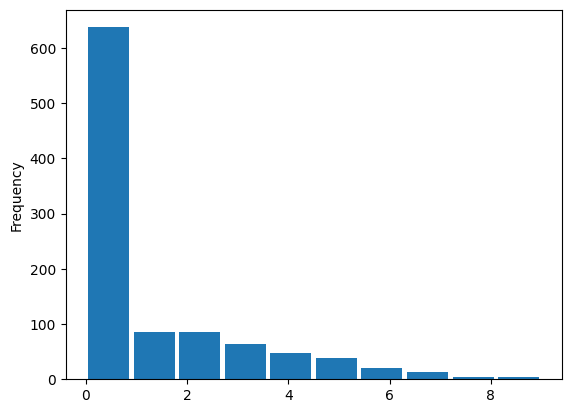

In [1036]:

num_bins = 10

train['binned_target'] = pd.cut(train['Scoville Heat Units (SHU)'], num_bins, labels=False)

# Print unique values of the binned target variable (these are the class labels)
print(sorted(train['binned_target'].unique()))

# Plot class histogram
train['binned_target'].plot.hist(rwidth=0.9) # rwidth is the width of the bars in the histogram plot

# source: 04_binning.ipynb

In [1037]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Assuming you have already defined 'train' DataFrame

# Define the columns to be one-hot encoded
categorical_cols = ['color', 'Harvest Time']

# Create a ColumnTransformer
ct = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first', dtype=int), categorical_cols)
    ],
    remainder='passthrough',  # Remainder columns will be passed through without any transformations
    verbose_feature_names_out=False,
)

# Apply the ColumnTransformer to the 'train' DataFrame
train = pd.DataFrame(ct.fit_transform(train), columns=ct.get_feature_names_out())
#test = pd.DataFrame(ct.transform(test), columns=ct.get_feature_names_out())

# Print the updated train DataFrame
train.head()


,color_red,color_yellow,Harvest Time_Midday,Harvest Time_Morning,Length (cm),Width (cm),Weight (g),Pericarp Thickness (mm),Seed Count,Capsaicin Content,Vitamin C Content (mg),Sugar Content,Moisture Content,Firmness,Average Daily Temperature During Growth (celcius),Scoville Heat Units (SHU),binned_target
0,1.0,0.0,1.0,0.0,17.37,5.42,94.30,4.90,193.93,3.21,173.59,6.15,88.59,3.40,8.68,0.00,0.0
1,0.0,0.0,1.0,0.0,27.78,4.75,262.71,6.56,186.29,8.19,100.41,2.36,111.20,5.45,22.44,0.00,0.0
2,1.0,0.0,1.0,0.0,6.17,3.51,66.72,7.96,298.81,4.69,125.91,6.75,72.98,2.77,24.99,455995.06,8.0
3,0.0,1.0,1.0,0.0,6.12,6.07,51.24,4.57,39.36,2.76,143.54,5.93,63.93,1.62,13.05,0.00,0.0
4,1.0,0.0,1.0,0.0,28.58,4.84,166.51,3.07,194.07,7.01,193.76,2.85,88.19,3.99,27.08,0.00,0.0


In [1038]:
# convert the categorical data to numerical data

# lage egne kolonner - one hot encoding
#train['Harvest Time'] = train['Harvest Time'].map({'Morning': 0, 'Midday': 1, 'Evening': 2})
#train['color'] = train['color'].map({'green': 0, 'yellow': 1,'red': 2}) # one hot encoding 

binary_encoded = pd.get_dummies(train[['color', 'Harvest Time']], drop_first=True)
binary_encoded = binary_encoded.astype(int) # convert the data type to integer from True/False
train = pd.concat([train.drop(['color', 'Harvest Time'], axis=1), binary_encoded], axis=1)

train.head()




KeyError: "None of [Index(['color', 'Harvest Time'], dtype='object')] are in the [columns]"

In [ ]:
# convert the categorical data to numerical data
#test['Harvest Time'] = test['Harvest Time'].map({'Morning': 0, 'Midday': 1, 'Evening': 2})
#test['color'] = test['color'].map({'green': 0, 'yellow': 1,'red': 2})

In [ ]:

# Using Z-scores to filter out the outliers
print(f'Shape of dataset before removing outliers: {train.shape}')
z_scores = stats.zscore(train)
abs_z_scores = np.abs(z_scores)
not_outliers = (abs_z_scores < 3).all(axis=1)
cleaned = train[not_outliers]

print(f'Shape of dataset after removing outliers: {cleaned.shape}')


Shape of dataset before removing outliers: (1000, 17)
Shape of dataset after removing outliers: (931, 17)


In [ ]:
# data preparation
# remove binned_target column
cleaned = cleaned.drop(columns=['remainder__binned_target'])
X = cleaned.drop(columns=['remainder__Scoville Heat Units (SHU)'])
y = cleaned['remainder__Scoville Heat Units (SHU)']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


In [ ]:
pcr = Pipeline([
    ('scaler', StandardScaler()),  # Scaler
    ('pca', PCA(n_components=1)),  
    ('clf', LinearRegression())    # Classifier
])

# Fit the pipeline
pcr.fit(X_train, y_train)

# Make predictions
predictions = pcr.predict(X_test)
print(predictions)

# source: Lectures/Lecture_19_20_Regression/PCR_regression.ipynb

[ 32567.62612576  71240.70873391   4528.87684777  23437.53422248
  70390.78334396  97492.60117508 109931.30469252 111979.47589788
  48726.32696926 103154.23448634  56892.53639141  29613.11373931
 115944.69083089  94522.91798595  40469.03515351  84653.44526885
  68221.73840903  83021.19442781  83446.60043754  61965.19027188
  84897.56045817 128457.46833729  74087.32862451  50856.77040463
  72055.46171375  97628.58380562 100153.70621483  50615.81104494
  83136.53484555  48844.15496646   4156.08210485  40578.30862057
  77631.43663127  90693.46247421 102665.00147196  50817.01114858
  84980.95003744  50705.93632758 109137.60490363  88544.8108909
 -33161.41630257  59159.56183629  67678.54468423  45836.39802602
  88500.04163931  86291.3666736   66058.37939729  58070.09294542
  56142.37621122  24508.69937578  36703.98596689 102576.14589873
  61882.25401978  95456.00200244  42478.74931521  85921.85258373
  87542.40719433  41143.5809682   87609.8927648    6062.09540813
  24860.41043757  90827.97

In [ ]:
y_pred = pcr.predict(test)
df_submission = pd.DataFrame({'Diagnosis': y_pred})
df_submission.reset_index(level=0, inplace=True)

df_submission.columns = ['index', 'Diagnosis']
df_submission.to_csv('submission_pcr.csv', index=False)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Average Daily Temperature During Growth (celcius)
- Capsaicin Content
- Firmness
- Harvest Time
- Length (cm)
- ...
Feature names seen at fit time, yet now missing:
- onehot__Harvest Time_Midday
- onehot__Harvest Time_Morning
- onehot__color_red
- onehot__color_yellow
- remainder__Average Daily Temperature During Growth (celcius)
- ...


### A - Regression 

In [ ]:

# Pipeline for Regression Analysis
pipeline_reg = Pipeline( steps = [
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

#
# Fit the pipeline to the training data
pipeline_reg.fit(X, y)



Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [ ]:
lin_reg = LinearRegression()
rmse_list = []

# First generate all the principal components
pca = PCA()
X_train_pc = pca.fit_transform(X_train_scaled)

print(f'PCA data shape: {X_train_pc.shape}')

# Loop through different count of principal components for linear regression
for i in range(1, X_train_pc.shape[1]+1):
    rmse_score = -1 * cross_val_score(lin_reg, 
                                      X_train_pc[:,:i], # Use first k principal components
                                      y_train, 
                                      cv=cv, 
                                      scoring='neg_root_mean_squared_error').mean()
    rmse_list.append(rmse_score)
    print(f'{i}. principle component: {rmse_score}')

NameError: name 'X_train_scaled' is not defined

### Linear Regression

In [ ]:
pcr = Pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)
pcr.predict(X_test)

# source: Lecture_19_20_Regression/PCR_regression.ipynb

TypeError: Pipeline.__init__() takes 2 positional arguments but 4 were given

In [ ]:
pipeline_A = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', LinearRegression())])

# Pipeline B: Multi-class Classification Analysis with Random Forest Regressor
pipeline_B = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', RandomForestRegressor())])

# Pipeline C: Two-step Analysis with Random Forest Classifier and Linear Regression
pipeline_C = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', RandomForestClassifier()),
                             ('regressor', LinearRegression())])

In [ ]:
# Hyperparameters for Pipeline B (Random Forest Regressor)
param_grid_B = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Grid search for best hyperparameters
grid_search_B = GridSearchCV(pipeline_B, param_grid_B, cv=5, scoring='neg_mean_squared_error')
grid_search_B.fit(X, y)

print("Best MAE:", -grid_search_B.best_score_)
print("Best parameters:", grid_search_B.best_params_)
